In [1]:
!pip install napari aicsimageio tifffile matplotlib scikit-image==0.17.2

In [2]:
import warnings
warnings.filterwarnings('ignore')

import json

import tifffile
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
# import napari

from os import getcwd, mkdir, path
from shutil import rmtree

from aicsimageio.readers import CziReader
from skimage import img_as_float, img_as_ubyte

In [3]:
def showXYZprojn(img, voxel_sz_x, voxel_sz_y, voxel_sz_z, cmap='gray'):
    aspect_xz = voxel_sz_z / voxel_sz_x
    aspect_yz = voxel_sz_z / voxel_sz_y
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 8))

    axes[0].imshow(np.max(img, axis=0), cmap=cmap)
    axes[1].imshow(np.max(img, axis=1), cmap, aspect=aspect_xz)
    axes[2].imshow(np.max(img, axis=2), cmap, aspect=aspect_yz)
    plt.show()

## Import Confocal Microscopic Image of the Tissue

Set `CONFOCAL_TISSUE_IMAGE` to the path of the image file to be processed.

In [4]:
CONFOCAL_TISSUE_IMAGE = 'Datasets/STAB DEC/SW 1SEC2 CA1 A CONTRA.czi'

# image has to be converted to float for processing
if CONFOCAL_TISSUE_IMAGE.split('.')[-1] == 'czi':
    original = CziReader(CONFOCAL_TISSUE_IMAGE)
    original = original.data
    original = img_as_float(np.squeeze(original)[0])
else:
    original = img_as_float(io.imread(CONFOCAL_TISSUE_IMAGE))

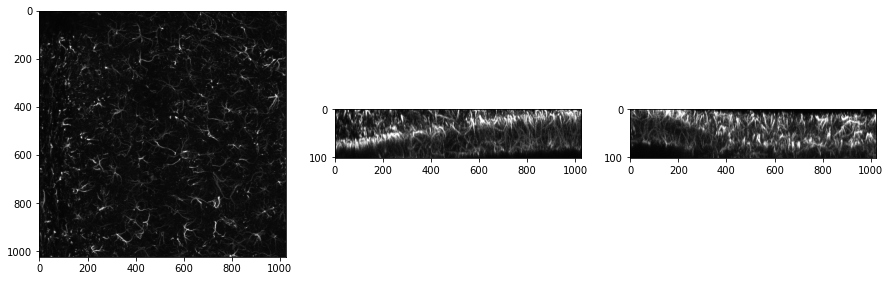

In [5]:
showXYZprojn(original, .5, .5, 1)

## Denoise with Global parameters

### 1. Calibrating Denoisers Using J-Invariance

In [6]:
from skimage.restoration import calibrate_denoiser, denoise_nl_means, estimate_sigma

original_max_projection = np.max(original, 0)
sigma_est = estimate_sigma(original_max_projection)

parameter_ranges = {'h': np.arange(.8, 1.2, .2) * sigma_est,
                    'patch_size': np.arange(2, 6),  # higher, lesser particles
                    'patch_distance': np.arange(2, 6)}  # lesser, more branching maintained

denoiser = calibrate_denoiser(original_max_projection, denoise_nl_means, parameter_ranges)
denoise_parameters = denoiser.keywords['denoiser_kwargs']
denoise_parameters

{'h': 0.017506666757888208, 'patch_size': 4, 'patch_distance': 2}

### 2. Denoise with Non-local means using calibrated parameters

In [7]:
denoised = np.zeros(original.shape)

for i in range(denoised.shape[0]):
    denoised[i] = denoise_nl_means(original[i], **denoise_parameters)

In [8]:
# with napari.gui_qt():
#     viewer = napari.view_image(original, colormap='gray', name='original')
#     viewer.add_image(denoised, colormap='inferno', name='denoised')

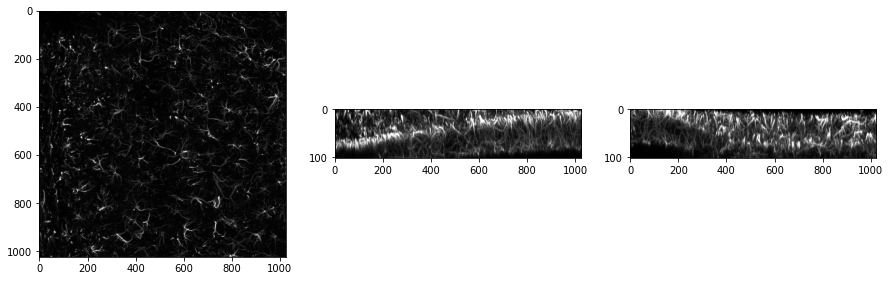

In [9]:
showXYZprojn(denoised, .5, .5, 1)

## Segmentation

### 1. Edge filtering

In [10]:
from skimage.filters import sobel

def sobel_layered(image):
    sobel_edges = np.zeros(image.shape)

    for j in range(image.shape[0]):
        sobel_edges[j] = sobel(image[j])

    return sobel_edges

sobel_edges = sobel_layered(original)

In [11]:
# with napari.gui_qt():
#     viewer = napari.view_image(denoised)
#     viewer.add_image(sobel_edges, colormap='inferno')

### 2. Threshold & color label cells

Set two parameters:
- `LOW_THRESH`: Pixel intensity value corresponding to faintest branch's edge
- `HIGH_THRESH`: Pixel intensity value corresponding to faintest soma

In [12]:
from skimage.filters import apply_hysteresis_threshold

LOW_THRESH = .035
HIGH_THRESH = .45

thresholded = apply_hysteresis_threshold(sobel_edges, LOW_THRESH, HIGH_THRESH)

In [13]:
from skimage.measure import label

labels = label(thresholded)

In [14]:
# with napari.gui_qt():
#     viewer = napari.view_image(original)
#     viewer.add_image(denoised, colormap='inferno')
#     viewer.add_image(labels, colormap='gist_earth', gamma=.8)

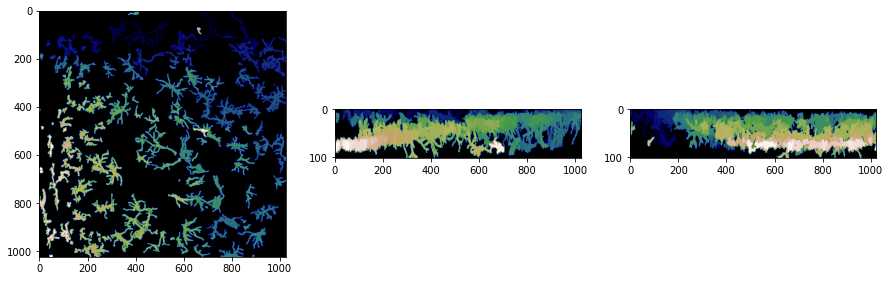

In [15]:
showXYZprojn(labels, .5, .5, 1, 'gist_earth')

### 3. Find convex hull that approximates tissue structure

In [16]:
from skimage.morphology import binary_erosion, convex_hull_image

surface = thresholded ^ binary_erosion(thresholded)

In [17]:
from scipy.spatial import ConvexHull
from skimage.util import unique_rows
from psutil import virtual_memory

def _check_coords_in_hull(gridcoords, hull_equations, tolerance):
    ndim, n_gridcoords = gridcoords.shape
    coords_in_hull = np.zeros(n_gridcoords, dtype=np.bool_)
    n_hull_equations = hull_equations.shape[0]

    available_mem = .75 * virtual_memory().available
    required_mem = 96 + n_hull_equations * n_gridcoords * 8
    chunk_size = int(required_mem // available_mem) if available_mem < required_mem else n_gridcoords

    dot_array = np.zeros((n_hull_equations, chunk_size))
    test_ineq_temp = np.zeros((n_hull_equations, chunk_size))

    # Apply the test in chunks
    for idx in range(0, n_gridcoords, chunk_size):
        coords = gridcoords[:, idx : idx + chunk_size]
        n_coords = coords.shape[1]

        if n_coords == chunk_size:
            np.dot(hull_equations[:, :ndim], coords, out=dot_array if n_coords == chunk_size else None)
            np.add(dot_array, hull_equations[:, ndim:], out=test_ineq_temp if n_coords == chunk_size else None)
            coords_in_hull[idx : idx + chunk_size] = np.all(test_ineq_temp[:, :n_coords] < tolerance, axis=0)
        else:
            coords_in_hull[idx : idx + chunk_size] = np.all(
                np.add(
                    np.dot(hull_equations[:, :ndim], coords),
                    hull_equations[:, ndim:]
                ) < tolerance,
                axis=0
            )

    return coords_in_hull

def convex_hull_image(image, tolerance=1e-10):
    ndim = image.ndim
    if np.count_nonzero(image) == 0:
        return np.zeros(image.shape, dtype=np.bool_)

    # 3d only
    coords = np.transpose(np.nonzero(image))

    # repeated coordinates can *sometimes* cause problems in
    # scipy.spatial.ConvexHull, so we remove them.
    coords = unique_rows(coords)

    # Find the convex hull
    hull = ConvexHull(coords)
    vertices = hull.points[hull.vertices]

    gridcoords = np.reshape(np.mgrid[tuple(map(slice, image.shape))], (ndim, -1))
    # A point is in the hull if it satisfies all of the hull's inequalities
    coords_in_hull = _check_coords_in_hull(gridcoords, hull.equations, tolerance)
    mask = np.reshape(coords_in_hull, image.shape)

    return mask

In [18]:
convex_hull = convex_hull_image(surface)

In [19]:
# with napari.gui_qt():
#     viewer = napari.view_image(denoised)
#     viewer.add_image(thresholded, colormap='red')
#     viewer.add_image(convex_hull, colormap='yellow')

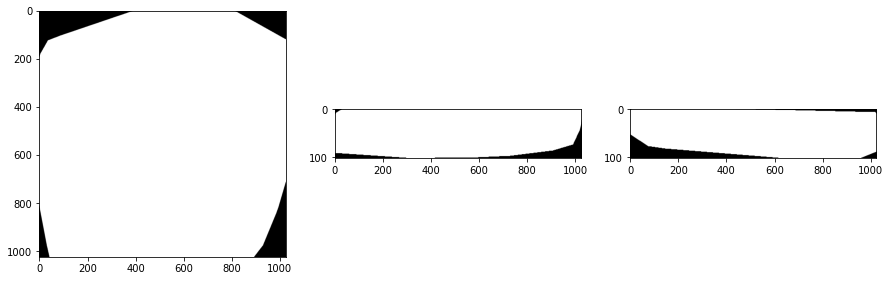

In [20]:
showXYZprojn(convex_hull, .5, .5, 1)

### 4. Filter segmented individual cells by removing ones in borders

In [21]:
from skimage.segmentation import clear_border
from skimage.measure import regionprops

# discard objects connected to border of approximated tissue, potential partially captured
filtered_labels = clear_border(clear_border(labels), mask=binary_erosion(convex_hull))

In [22]:
# with napari.gui_qt():
#     viewer = napari.view_image(filtered_labels)
#     viewer.add_image(labels, colormap='gist_earth')
#     viewer.add_image(convex_hull, colormap='yellow')

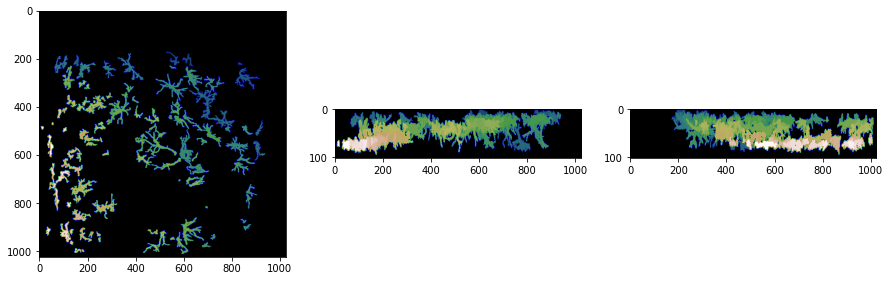

In [23]:
showXYZprojn(filtered_labels, .5, .5, 1, 'gist_earth')

### 5. Arrange detected objects in ascending order of volume

In [24]:
regions = sorted(regionprops(filtered_labels), key=lambda region: region.area)
print(f'{len(regions)} objects detected.')

107 objects detected.


### 6. Visualize segmented cells to determine cutoff volumes

In [25]:
max_idx = -4

minz, miny, minx, maxz, maxy, maxx = regions[max_idx].bbox

extracted_cell = denoised[minz:maxz, miny:maxy, minx:maxx].copy()
extracted_cell[~regions[max_idx].filled_image] = 0.0
f'Volume of cell at index {max_idx} is: {regions[max_idx].area}'

'Volume of cell at index -4 is: 22468'

In [26]:
# with napari.gui_qt():
#     viewer = napari.view_image(denoised[minz:maxz, miny:maxy, minx:maxx], name='denoised')
#     viewer.add_image(regions[max_idx].image, colormap='yellow', name='thresholded')
#     viewer.add_image(extracted_cell, colormap='inferno')

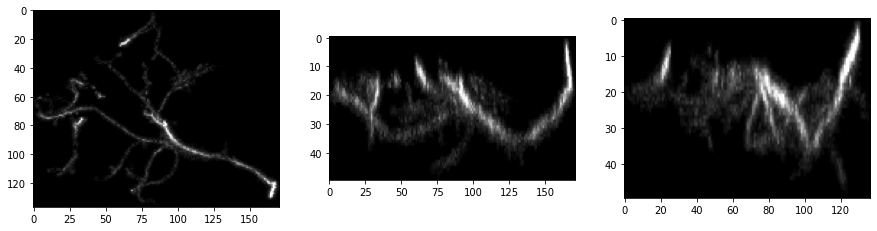

In [27]:
showXYZprojn(extracted_cell, .5, .5, 1)

## Export autocropped 3D cells or 2D max intensity projections

Set two parameters:
- `LOW_VOLUME_CUTOFF`: to filter out noise/artifacts
- `HIGH_VOLUME_CUTOFF`: to filter out cell clusters

For choosing between 3D segmented cells or 2D max intensity projections:
- Set `OUTPUT_OPTION` = 0 for 3D cells, or
- Set `OUTPUT_OPTION` = 1 for Max Intensity Projections.

In [28]:
LOW_VOLUME_CUTOFF = 1600  # filter noise/artifacts
HIGH_VOLUME_CUTOFF = 33000  # filter cell clusters

OUTPUT_OPTION = 0  # 0 for 3D cells, 1 for Max Intensity Projections

OUTPUT_TYPE = ('3D', 'MIP')[OUTPUT_OPTION]

DIR = getcwd() + '/autocropped/'
if not (path.exists(DIR) and path.isdir(DIR)):
    mkdir(DIR)

IMAGE_NAME = path.basename(CONFOCAL_TISSUE_IMAGE).split('.')[0]
OUTPUT_DIR = DIR + IMAGE_NAME + f'_{OUTPUT_TYPE}/'
if path.exists(OUTPUT_DIR) and path.isdir(OUTPUT_DIR):
    rmtree(OUTPUT_DIR)
mkdir(OUTPUT_DIR)

if CONFOCAL_TISSUE_IMAGE.split('.')[-1] == 'tif':
    with tifffile.TiffFile(CONFOCAL_TISSUE_IMAGE) as file:
        metadata = file.imagej_metadata

    cell_metadata = {}
    cell_metadata['unit'] = metadata['unit']
    cell_metadata['spacing'] = metadata['spacing']
    cell_metadata = json.dumps(cell_metadata)
else:
    cell_metadata = None

for region in regions:
    if LOW_VOLUME_CUTOFF < region.area < HIGH_VOLUME_CUTOFF:
        minz, miny, minx, maxz, maxy, maxx = region.bbox

        segmented = img_as_ubyte(denoised[minz:maxz, miny:maxy, minx:maxx].copy())
        segmented[~region.filled_image] = 0

        out_data = segmented if OUTPUT_TYPE == '3D' else np.max(segmented, 0)

        name = f'{OUTPUT_DIR}cell_{minz}-{maxz}_{miny}-{maxy}_{minx}-{maxx}.tif'
        tifffile.imsave(name, out_data, description=cell_metadata)